In [1]:
import pandas as pd

In [2]:
DVF_FILE = '../data/raw/dvf.csv'

CHUNK_SIZE = 200_000

USECOLS = [
    'id_mutation',
    'date_mutation',
    'nature_mutation',
    'type_local',
    'valeur_fonciere',
    'surface_reelle_bati',
    'longitude',
    'latitude',
    'code_departement',
    'nom_commune',
    'surface_terrain',
    'nombre_pieces_principales'
]

DTYPES = {
    'id_mutation'         : 'string',
    'nature_mutation'     : 'category',
    'type_local'          : 'category',
    'valeur_fonciere'     : 'float64',
    'surface_reelle_bati' : 'float64',
    'longitude'           : 'float64',
    'latitude'            : 'float64',
    'code_departement'    : 'string',
    'nom_commune'         : 'string',
    'surface_terrain'     : 'float64',
    'nombre_pieces_principales': 'float64',
}

vente_types       = ['Vente']
residentiel_types = ['Maison', 'Appartement']

filtered_chunks = []

# Étape 1 : Lecture chunk par chunk + premier nettoyage
with pd.read_csv(
    DVF_FILE,
    usecols=USECOLS,
    dtype=DTYPES,
    parse_dates=['date_mutation'],
    chunksize=CHUNK_SIZE,
    low_memory=False
) as reader:
    for chunk in reader:
        chunk.columns = chunk.columns.str.strip()
        chunk = chunk.dropna(how='any')
        chunk = chunk.drop_duplicates()
        chunk = chunk[chunk['nature_mutation'].isin(vente_types)]
        chunk = chunk[chunk['type_local'].isin(residentiel_types)]
        if not chunk.empty:
            filtered_chunks.append(chunk)

# Étape 2 : Concaténation des chunks
if filtered_chunks:
    df = pd.concat(filtered_chunks, ignore_index=True).drop_duplicates()
else:
    df = pd.DataFrame(columns=USECOLS)

### Valeur foncière 

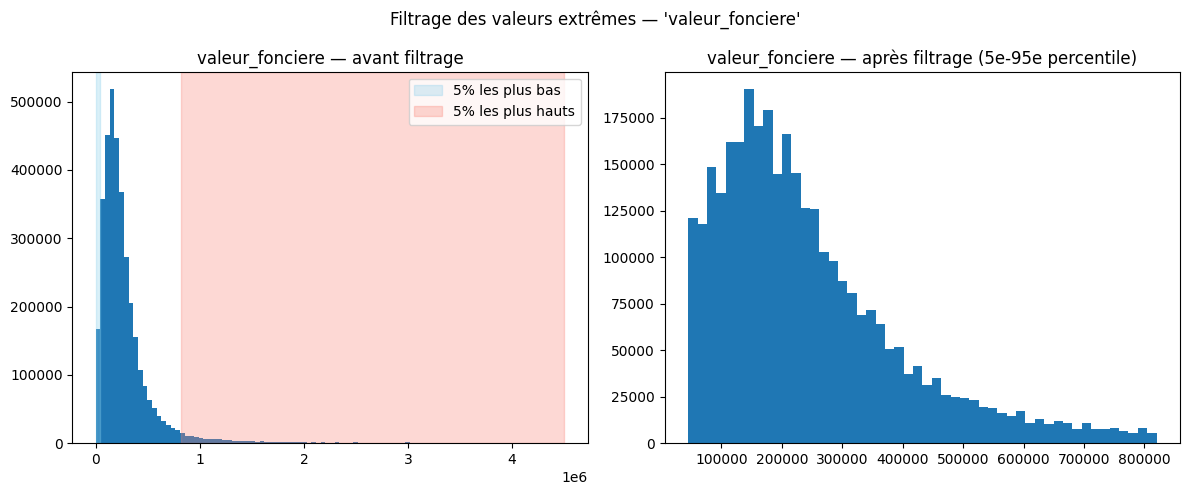

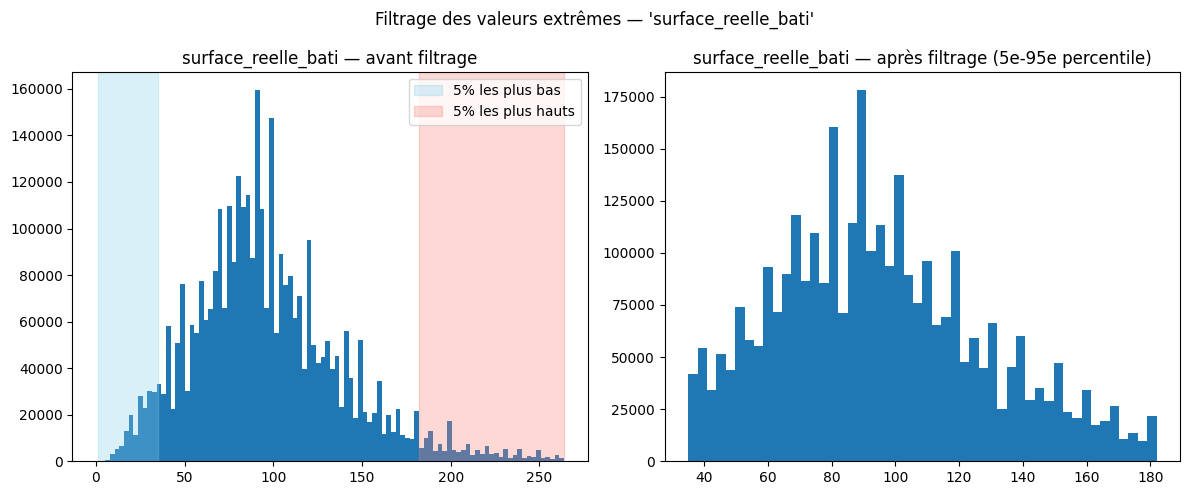

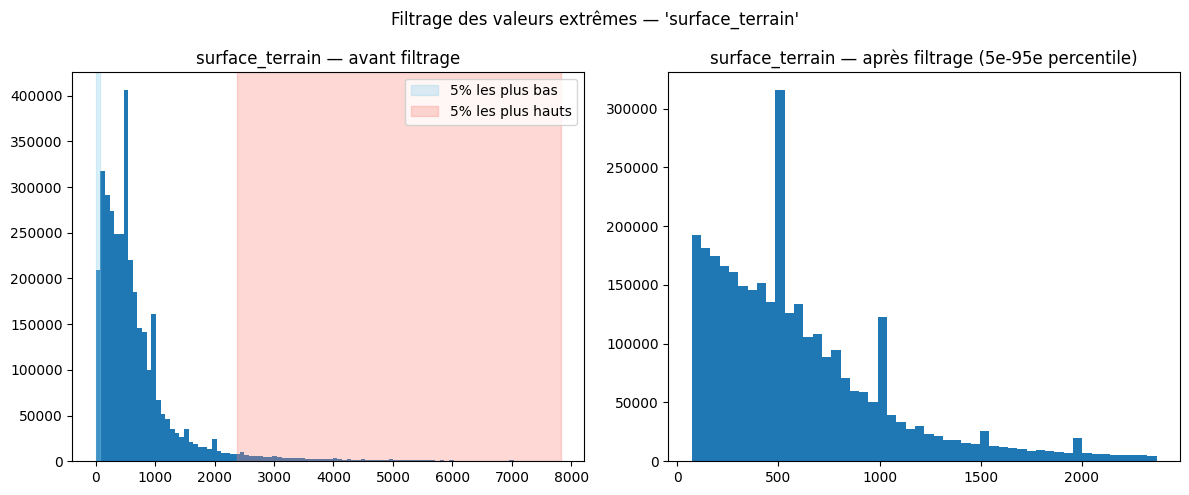

In [3]:
import matplotlib.pyplot as plt

cols = ['valeur_fonciere', 'surface_reelle_bati', 'surface_terrain']

for col in cols:
    q_low = df[col].quantile(0.05)
    q_high = df[col].quantile(0.95)
    x_max = df[col].quantile(0.99)  # Limite l'axe X pour la lisibilité
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # 1. Histogramme AVANT filtrage
    ax[0].hist(df[col], bins=100, range=(0, x_max))
    ax[0].axvspan(df[col].min(), q_low, color='skyblue', alpha=0.3, label='5% les plus bas')
    ax[0].axvspan(q_high, x_max, color='salmon', alpha=0.3, label='5% les plus hauts')
    ax[0].set_title(f"{col} — avant filtrage")
    ax[0].legend()

    # 2. Histogramme APRÈS filtrage
    filtered = df[(df[col] >= q_low) & (df[col] <= q_high)]
    ax[1].hist(filtered[col], bins=50)
    ax[1].set_title(f"{col} — après filtrage (5e-95e percentile)")

    plt.suptitle(f"Filtrage des valeurs extrêmes — '{col}'")
    plt.tight_layout()
    plt.show()


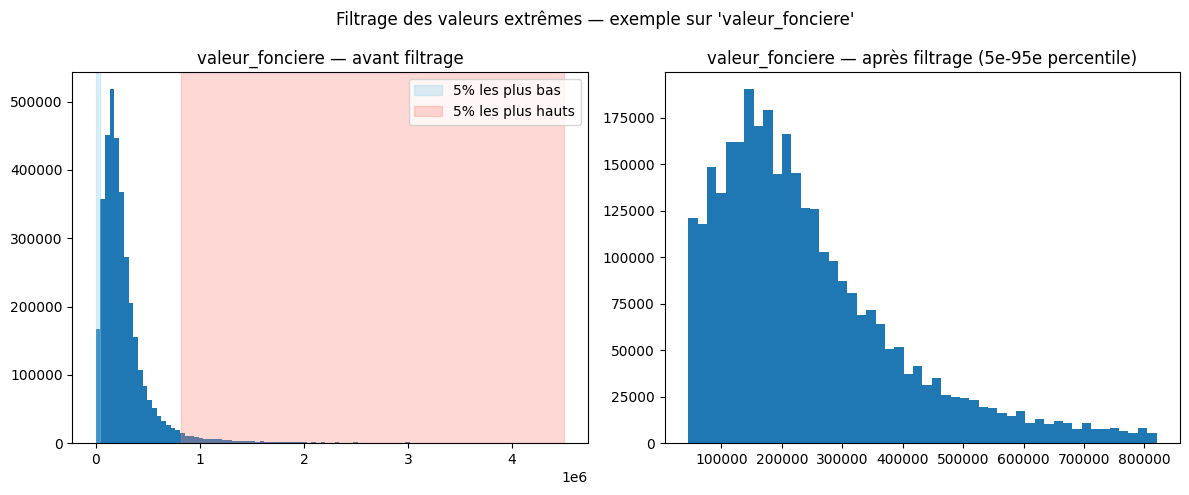

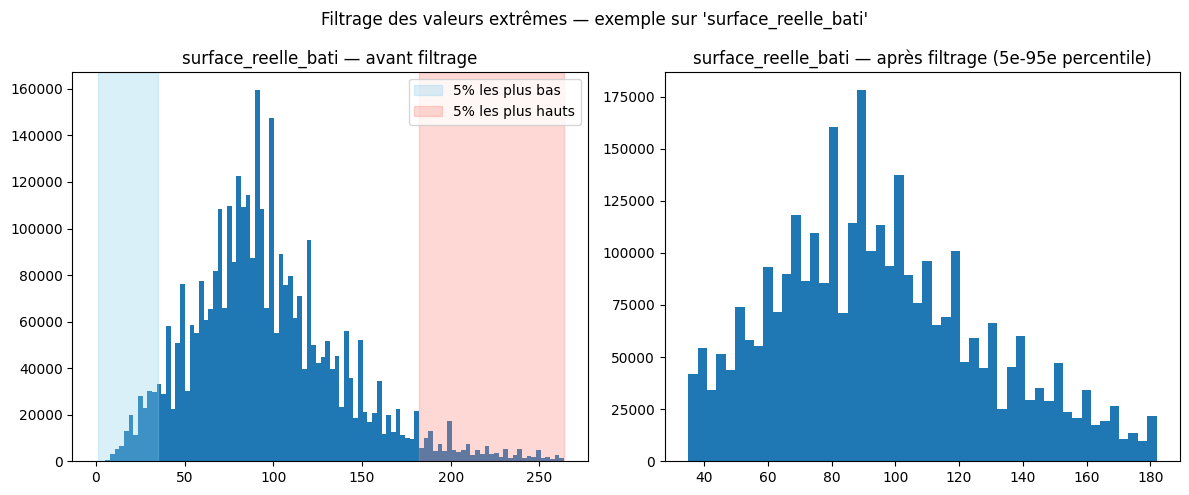

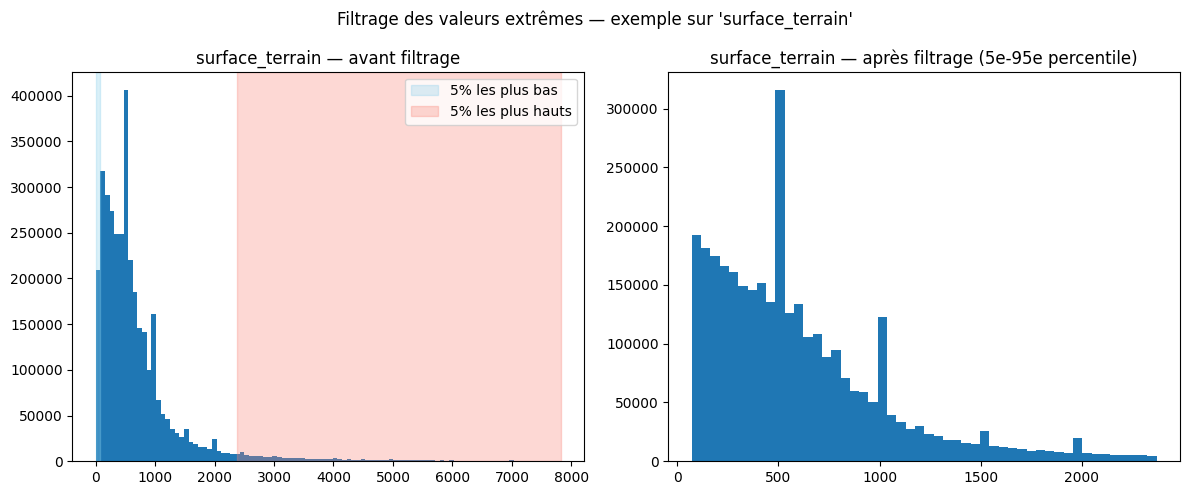

In [4]:
import matplotlib.pyplot as plt

cols = ['valeur_fonciere', 'surface_reelle_bati', 'surface_terrain']

for col in cols:
    q_low = df[col].quantile(0.05)
    q_high = df[col].quantile(0.95)
    x_max = df[col].quantile(0.99)  # Limite l'axe X pour la lisibilité
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # 1. Histogramme AVANT filtrage
    ax[0].hist(df[col], bins=100, range=(0, x_max))
    ax[0].axvspan(df[col].min(), q_low, color='skyblue', alpha=0.3, label='5% les plus bas')
    ax[0].axvspan(q_high, x_max, color='salmon', alpha=0.3, label='5% les plus hauts')
    ax[0].set_title(f"{col} — avant filtrage")
    ax[0].legend()

    # 2. Histogramme APRÈS filtrage
    filtered = df[(df[col] >= q_low) & (df[col] <= q_high)]
    ax[1].hist(filtered[col], bins=50)
    ax[1].set_title(f"{col} — après filtrage (5e-95e percentile)")

    plt.suptitle(f"Filtrage des valeurs extrêmes — exemple sur '{col}'")
    plt.tight_layout()
    plt.show()


In [5]:
df.shape

(3569135, 12)

In [6]:
for col in ['valeur_fonciere', 'surface_reelle_bati', 'surface_terrain']:
    q_low = df[col].quantile(0.05)
    q_high = df[col].quantile(0.95)
    df = df[(df[col] >= q_low) & (df[col] <= q_high)]

### Garder que la métropole

In [7]:
df = df[
    (df['longitude'] >= -5) & (df['longitude'] <= 10) &
    (df['latitude'] >= 41) & (df['latitude'] <= 52)
]

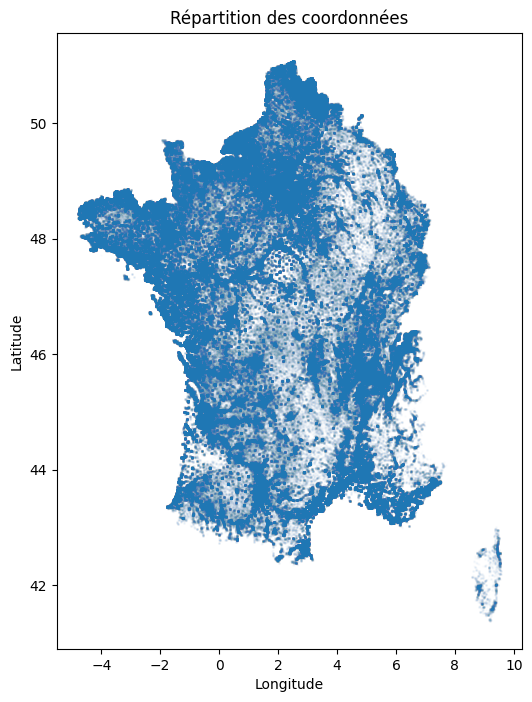

In [8]:
plt.figure(figsize=(6, 8))
plt.scatter(df['longitude'], df['latitude'], alpha=0.01, s=1)
plt.title("Répartition des coordonnées")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [9]:
df.shape

(2595207, 12)

In [10]:
df['prix_m2'] = df['valeur_fonciere'] / df['surface_reelle_bati']
df['prix_m2'] = df['prix_m2'].round(2)

In [11]:
df['annee'] = df['date_mutation'].dt.year
df['mois']  = df['date_mutation'].dt.month
df['jour']  = df['date_mutation'].dt.day

In [12]:
df.head(2)

,id_mutation,date_mutation,nature_mutation,valeur_fonciere,nom_commune,code_departement,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,prix_m2,annee,mois,jour
1,2020-7,2020-01-06,Vente,180300.0,Bourg-en-Bresse,01,Maison,75.0,4.0,525.0,5.208899,46.196870,2404.0,2020,1,6
4,2020-11,2020-01-10,Vente,53650.0,Coligny,01,Appartement,50.0,2.0,195.0,5.347202,46.388082,1073.0,2020,1,10


### Filosofie

In [13]:
META_FILOSOFI = '../data/meta_filosofi.csv'

metafilosofi_df = pd.read_csv(META_FILOSOFI, sep=";")

FileNotFoundError: [Errno 2] No such file or directory: '../data/meta_filosofi.csv'

In [ ]:
metafilosofi_df.head(30)

,COD_VAR,LIB_VAR,LIB_VAR_LONG,COD_MOD,LIB_MOD,TYPE_VAR,LONG_VAR
0,IRIS,IRIS,Code du département suivi du numéro de commune...,NaN,NaN,CHAR,9
1,DEC_PIMP21,Part des ménages fiscaux imposés (%),Part des ménages fiscaux imposés (%),NaN,NaN,CHAR,4
2,DEC_TP6021,Taux de bas revenus déclarés au seuil de 60 % (%),Taux de bas revenus déclarés au seuil de 60 % ...,NaN,NaN,CHAR,4
3,DEC_INCERT21,Incertitude sur les indicateurs DEC_TP6021 et ...,Incertitude sur le taux de bas revenus et la p...,1,IRIS de 1 000 à moins de 10 000 ménages : à l’...,CHAR,2
4,DEC_INCERT21,Incertitude sur les indicateurs DEC_TP6021 et ...,Incertitude sur le taux de bas revenus et la p...,2,IRIS de 500 à moins de 1 000 ménages : à l’ent...,CHAR,2
5,DEC_Q121,1ᵉʳ quartile (€),1ᵉʳ quartile du revenu déclaré par unité de co...,NaN,NaN,CHAR,5
6,DEC_MED21,Médiane (€),Médiane du revenu déclaré par unité de consomm...,NaN,NaN,CHAR,5
7,DEC_Q321,3ᵉ quartile (€),3ᵉ quartile du revenu déclaré par unité de con...,NaN,NaN,CHAR,6
8,DEC_EQ21,Écart inter-quartile rapporté à la médiane,Écart inter-quartile rapporté à la médiane du ...,NaN,NaN,CHAR,4
9,DEC_D121,1ᵉʳ décile (€),1ᵉʳ décile du revenu déclaré par unité de cons...,NaN,NaN,CHAR,5


In [ ]:
FILOSOFI_CSV = '../data/filosofie.csv'

filosofi = pd.read_csv(
    FILOSOFI_CSV,
    sep=';',
    na_values=['na', 'sne', 's']
)

# S'assurer que le code IRIS est bien formaté
filosofi['IRIS'] = filosofi['IRIS'].astype(str).str.zfill(9)

# Sélection et renommage des colonnes pour plus de clarté
filosofi = filosofi.rename(columns={
    'IRIS': 'CODE_IRIS',
    'DEC_PIMP21': 'POP21',
    'DEC_MED21': 'REV_MED21',
    'DEC_TP6021': 'TX_PAUVRETE21',
    'DEC_GI21': 'GINI21',           # optionnel
    'DEC_RD21': 'RAPPORT_D9D1_21',  # optionnel
})

# Conversion numérique avec sécurité sur les NaN
for col in ['POP21', 'REV_MED21', 'TX_PAUVRETE21', 'GINI21', 'RAPPORT_D9D1_21']:
    if col in filosofi.columns:
        filosofi[col] = pd.to_numeric(filosofi[col], errors='coerce')

# Option : extraire le code commune si besoin (fusion commune)
filosofi['CODE_COMMUNE'] = filosofi['CODE_IRIS'].str[:5]

# Supprimer les lignes sans revenu médian (ou autre critère fort)
filosofi_clean = filosofi.dropna(subset=['REV_MED21'])

print(filosofi_clean[['CODE_IRIS', 'CODE_COMMUNE', 'POP21', 'REV_MED21', 'TX_PAUVRETE21']].head())

filosofi_clean.shape


   CODE_IRIS CODE_COMMUNE  POP21  REV_MED21  TX_PAUVRETE21
0  010040101        01004    NaN    19330.0            NaN
1  010040102        01004    NaN    16830.0            NaN
2  010040201        01004    NaN    19940.0            NaN
3  010040202        01004    NaN    25560.0            NaN
4  010330102        01033    NaN    19870.0            NaN


(14490, 27)

In [ ]:
print(filosofi_clean.isnull().sum())


CODE_IRIS              0
POP21              14490
TX_PAUVRETE21      14490
DEC_INCERT21           0
DEC_Q121               0
REV_MED21              0
DEC_Q321               0
DEC_EQ21               0
DEC_D121               0
DEC_D221               0
DEC_D321               0
DEC_D421               0
DEC_D621               0
DEC_D721               0
DEC_D821               0
DEC_D921               0
RAPPORT_D9D1_21    14490
DEC_S80S2021           0
GINI21             14490
DEC_PACT21             0
DEC_PTSA21           222
DEC_PCHO21           222
DEC_PBEN21           222
DEC_PPEN21             0
DEC_PAUT21             0
DEC_NOTE21             0
CODE_COMMUNE           0
dtype: int64


In [ ]:
colonnes_utiles = ['CODE_IRIS', 'CODE_COMMUNE', 'REV_MED21', 'DEC_Q121', 'DEC_Q321']
filosofi_clean = filosofi_clean[colonnes_utiles].copy()

In [ ]:
import geopandas as gpd

iris = gpd.read_file('../data/iris.gpkg')

print(iris.crs)
print(f"IRIS columns: {iris.columns}")



EPSG:2154
IRIS columns: Index(['cleabs', 'code_insee', 'nom_commune', 'iris', 'code_iris', 'nom_iris',
       'type_iris', 'geometry'],
      dtype='object')


In [ ]:
import geopandas as gpd

# 1. Création du GeoDataFrame DVF (en EPSG:4326)
gdf_dvf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
    crs='EPSG:4326'
)

# 2. Reprojection en EPSG:2154 pour matcher l’IRIS
gdf_dvf = gdf_dvf.to_crs("EPSG:2154")

# 3. Jointure spatiale (on utilise bien 'code_iris' du fichier iris.gpkg)
dvf_iris = gpd.sjoin(
    gdf_dvf, 
    iris[['code_iris', 'geometry']], 
    how='left', 
    predicate='within'
)

# 4. Harmonisation du nom pour la fusion avec Filosofi
dvf_iris = dvf_iris.rename(columns={'code_iris': 'CODE_IRIS'})

# (Optionnel) Vérification du résultat
print(dvf_iris[['CODE_IRIS', 'geometry']].head())

   CODE_IRIS                        geometry
1  010530203  POINT (870319.407 6568718.842)
4  011080000  POINT (880349.236 6590251.676)
5  011080000  POINT (880349.236 6590251.676)
6  014220000  POINT (878368.546 6562735.969)
7  012640000  POINT (863627.961 6568172.906)


In [ ]:
dvf_iris['CODE_IRIS'].isnull().sum()

np.int64(17)

In [ ]:
dvf_iris = dvf_iris[~dvf_iris['CODE_IRIS'].isnull()]
dvf_iris.shape

(2595190, 19)

In [ ]:
print('DVF IRIS uniques:', dvf_iris['CODE_IRIS'].nunique())
print('Filosofi IRIS uniques:', filosofi_clean['CODE_IRIS'].nunique())

DVF IRIS uniques: 43723
Filosofi IRIS uniques: 14490


In [ ]:
print(dvf_iris[~dvf_iris['CODE_IRIS'].isin(filosofi_clean['CODE_IRIS'])]['CODE_IRIS'].value_counts().head(10))

CODE_IRIS
140610000    979
144310000    774
146540000    719
850350000    695
220460000    692
766180000    671
143710000    671
492480000    646
850510000    641
492610000    640
Name: count, dtype: int64


In [ ]:
dvf_iris_filtre = dvf_iris[dvf_iris['CODE_IRIS'].isin(filosofi_clean['CODE_IRIS'])]

In [ ]:
final = dvf_iris_filtre.merge(filosofi_clean, on='CODE_IRIS', how='left')
print(final['REV_MED21'].isnull().sum())  # Ça devrait tomber à zéro ou presque

0


In [ ]:
final.shape

(953657, 23)

### Model 

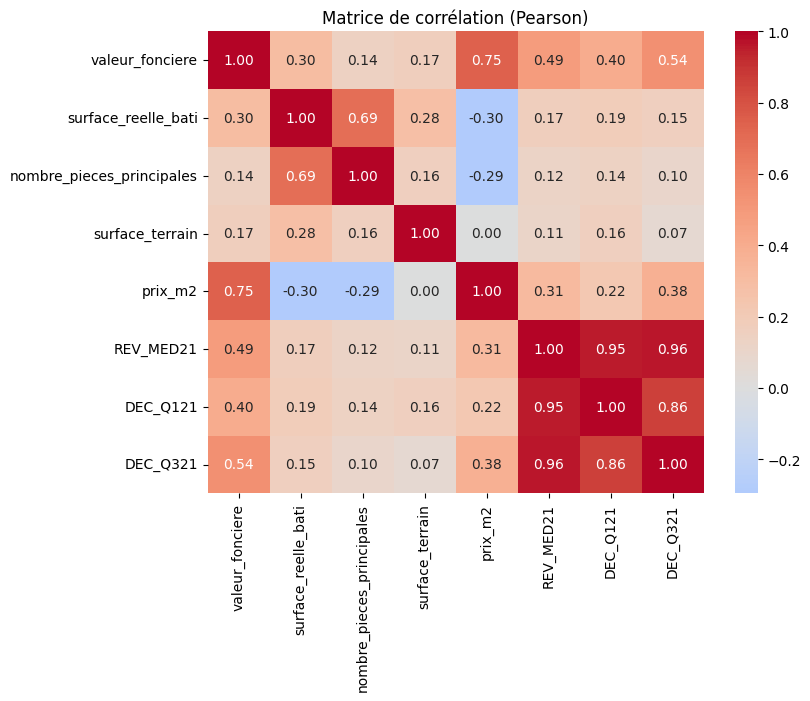

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Exemple de sélection de variables pertinentes
colonnes_num = [
    'valeur_fonciere',
    'surface_reelle_bati',''
    'nombre_pieces_principales',
    'surface_terrain',
    'prix_m2',         # à calculer si pas déjà fait : valeur_fonciere / surface_reelle_bati
    'REV_MED21',
    'DEC_Q121',        # 1er quartile
    'DEC_Q321',        # 3e quartile
    # Ajoute d'autres variables utiles...
]

# Filtre pour éviter les NaN (pandas le fait mais c'est mieux de cleaner un peu)
df_corr = final[colonnes_num].dropna()

# Matrice de corrélation
corr = df_corr.corr()

# Affichage joli
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Matrice de corrélation (Pearson)")
plt.show()


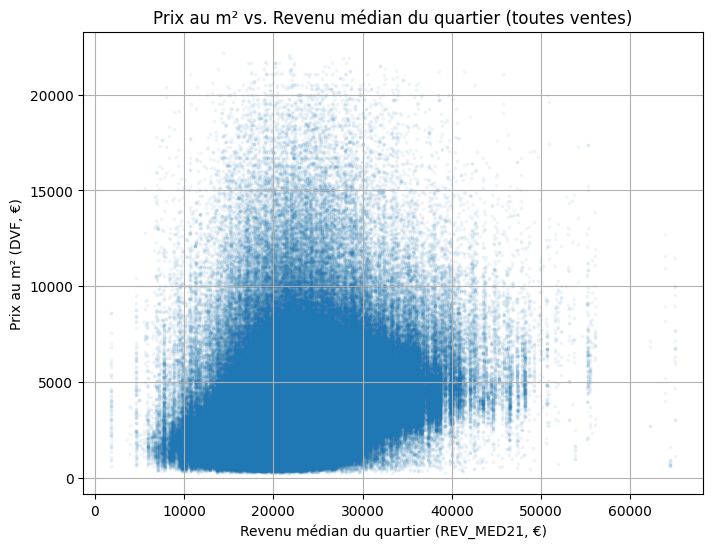

In [ ]:

plt.figure(figsize=(8,6))
plt.scatter(final['REV_MED21'], final['prix_m2'], alpha=0.05, s=3)  # alpha pour transparence, s pour taille des points
plt.xlabel("Revenu médian du quartier (REV_MED21, €)")
plt.ylabel("Prix au m² (DVF, €)")
plt.title("Prix au m² vs. Revenu médian du quartier (toutes ventes)")
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# --- 1. Sélection des variables
features = [
    'surface_reelle_bati',
    'surface_terrain',
    'type_local',
    'REV_MED21',
    'DEC_Q121',
    'DEC_Q321',
    'annee',
    'mois',
    'nombre_pieces_principales'
]

target = 'valeur_fonciere'

# --- 2. Nettoyage et préparation du dataset
df_model = final[features + [target]].dropna()

# --- 3. Encodage des variables catégorielles
df_model = pd.get_dummies(df_model, columns=['type_local'], drop_first=True)

# --- 4. Séparation X/y
X = df_model.drop(target, axis=1)
y = df_model[target]

# --- 5. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 6. Entraînement du modèle
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

# --- 7. Prédictions
y_pred = rf.predict(X_test)

# --- 8. Évaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f} €")
print(f"R² : {r2:.3f}")

# --- 9. (Optionnel) Importance des variables
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nImportance des variables :")
print(importances)

MAE : 63377.06 €
R² : 0.686

Importance des variables :
DEC_Q321                                               0.412350
surface_reelle_bati                                    0.141305
DEC_Q121                                               0.110233
surface_terrain                                        0.107747
REV_MED21                                              0.096718
mois                                                   0.051322
annee                                                  0.033168
nombre_pieces_principales                              0.025245
type_local_Maison                                      0.021912
type_local_Dépendance                                  0.000000
type_local_Local industriel. commercial ou assimilé    0.000000
dtype: float64


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb

# --- 1. Variables
features = [
    'surface_reelle_bati',
    'surface_terrain',
    'type_local',
    'REV_MED21',
    'DEC_Q121',
    'DEC_Q321',
    'annee',
    'mois',
    'nombre_pieces_principales'
]
target = 'valeur_fonciere'

# --- 2. Sélection et nettoyage du DataFrame
df_model = final[features + [target]].dropna()

# --- 3. Encodage de la variable catégorielle
df_model = pd.get_dummies(df_model, columns=['type_local'], drop_first=True)

# --- 4. Conversion en float pour les colonnes numériques
cols_float = [
    'surface_reelle_bati',
    'surface_terrain',
    'REV_MED21',
    'DEC_Q121',
    'DEC_Q321',
    'annee',
    'mois',
    'nombre_pieces_principales'
]
for col in cols_float:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

# --- 5. Dropna une dernière fois pour enlever les potentiels NaN restants
df_model = df_model.dropna()

# --- 6. Séparation X/y
X = df_model.drop(target, axis=1)
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 7. Entraînement XGBoost
xgb_reg = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42
)
xgb_reg.fit(X_train, y_train)

# --- 8. Prédictions
y_pred = xgb_reg.predict(X_test)

# --- 9. Évaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE XGBoost : {mae:.2f} €")
print(f"R² XGBoost : {r2:.3f}")

# --- 10. (Optionnel) Importance des variables
importances = pd.Series(xgb_reg.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nImportance des variables (XGBoost) :")
print(importances)

MAE XGBoost : 70482.97 €
R² XGBoost : 0.631

Importance des variables (XGBoost) :
DEC_Q321                                               0.424635
type_local_Maison                                      0.173625
surface_reelle_bati                                    0.126682
DEC_Q121                                               0.078116
REV_MED21                                              0.064304
annee                                                  0.045005
surface_terrain                                        0.043729
nombre_pieces_principales                              0.024566
mois                                                   0.019338
type_local_Dépendance                                  0.000000
type_local_Local industriel. commercial ou assimilé    0.000000
dtype: float32


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- 1. Sélection et préparation des variables
features = [
    'surface_reelle_bati',
    'surface_terrain',
    'type_local',
    'REV_MED21',
    'DEC_Q121',
    'DEC_Q321',
    'annee',
    'mois',
    'nombre_pieces_principales'
]
target = 'valeur_fonciere'

# --- 2. Nettoyage et encodage
df_model = final[features + [target]].dropna()
df_model = pd.get_dummies(df_model, columns=['type_local'], drop_first=True)

# Conversion en float pour toutes les variables numériques
cols_float = [
    'surface_reelle_bati',
    'surface_terrain',
    'REV_MED21',
    'DEC_Q121',
    'DEC_Q321',
    'annee',
    'mois',
    'nombre_pieces_principales'
]
for col in cols_float:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

df_model = df_model.dropna()

X = df_model.drop(target, axis=1)
y = df_model[target]

# --- 3. Standardisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 4. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# --- 5. Construction du modèle deep learning (MLP)
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Régression
])

model.compile(optimizer='adam', loss='mae', metrics=['mae'])

# --- 6. Entraînement
model.fit(X_train, y_train, epochs=10, batch_size=2048, validation_split=0.1)

# --- 7. Évaluation
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"MAE deep learning : {test_mae:.2f} €")

Epoch 1/10


c:\Users\Aymane\Desktop\project\price-property-prediction\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 279956.6562 - mae: 279956.6562 - val_loss: 222143.1406 - val_mae: 222143.1406
Epoch 2/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 166415.7812 - mae: 166415.7812 - val_loss: 105772.4062 - val_mae: 105772.4062
Epoch 3/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 103843.0703 - mae: 103843.0703 - val_loss: 100401.5156 - val_mae: 100401.5156
Epoch 4/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 99117.0547 - mae: 99117.0547 - val_loss: 96993.4062 - val_mae: 96993.4062
Epoch 5/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 96009.3906 - mae: 96009.3906 - val_loss: 94275.1328 - val_mae: 94275.1328
Epoch 6/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 93336.4062 - mae: 93336.4062 - val_loss: 92318.0859 - val_mae: 92318.0859
Epoch 7/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 91711.7500 - mae: 91711.7500 - val_loss: 91190.0234 - val_mae: 91190.0234
Epoch 8/10
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9